<a href="https://colab.research.google.com/github/Quang-Nguyen-Van/MSE-PYTHON/blob/main/BaiTap2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip uninstall gdown -y && pip install gdown


In [2]:
!rmdir dataset
!mkdir dataset

!gdown --folder https://drive.google.com/drive/folders/1DVCGeZnvEgdR9RQIhDaRTGHjeSGeCv7E?usp=sharing -O /content/dataset

rmdir: failed to remove 'dataset': No such file or directory
Retrieving folder list
Processing file 1fU2GsUOUgtkO-HQVgVLTOIqakyo-pZNf calendar.csv
Processing file 1lkeuWaNSb9qXxpu245d3WUXFBivKNb1I sales_train_evaluation.csv
Processing file 1tCyPqYmcvF6lOEepYulg8TCmSG_MQtlM sales_train_validation.csv
Processing file 1forbZUoCDs0vYSfsRiKgHy-WTZcd_znq sample_submission.csv
Processing file 1_tm_KeABM4cYjpk2bX_AqOZ-rNVOY7P3 sell_prices.csv
Processing file 17QFqGgzv5bNx8JtyXzkaHUjCXUP84XLK train.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1fU2GsUOUgtkO-HQVgVLTOIqakyo-pZNf
To: /content/dataset/calendar.csv
100% 103k/103k [00:00<00:00, 65.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lkeuWaNSb9qXxpu245d3WUXFBivKNb1I
To: /content/dataset/sales_train_evaluation.csv
100% 122M/122M [00:01<00:00, 111MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1tCyPqYmcvF6lOE

**Import thư viện và đọc file dữ liệu.**

In [3]:
import warnings
warnings.filterwarnings('ignore')
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


import os
for dirname, _, filenames in os.walk('/content/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/dataset/sample_submission.csv
/content/dataset/train.csv
/content/dataset/sales_train_evaluation.csv
/content/dataset/sales_train_validation.csv
/content/dataset/sell_prices.csv
/content/dataset/calendar.csv


**Load data into the pandas dataframes**

In [4]:
sale_train = pd.read_csv('/content/dataset/sales_train_validation.csv')
sale_train_cp = pd.read_csv('/content/dataset/sales_train_validation.csv')
calenda = pd.read_csv('/content/dataset/calendar.csv')
sell_prices = pd.read_csv("/content/dataset/sell_prices.csv")

In [5]:
d_cols = [c for c in sale_train.columns if 'd_' in c]

x = datetime.date(2011,1,29)

for c in ((sale_train.columns)[6:]): # đọc dữ liệu từ cột 6 đến cột cuối cùng. [6: -1]
    sale_train.rename(columns={c:x},inplace=True) # đổi tên cột từ d_* qua chuỗi năm-tháng-ngày (YYYY-mm-dd)
    x = x + datetime.timedelta(days=1) # tăng thêm 1 ngày

**Đổi tên các cột trong dataset theo dạng YYYY-mm-dd**

from d_* to corresponding date

#**Doanh số của 4 mặt hàng đầu tiên theo thời gian (ngày).**

In [6]:
items_df = sale_train_cp.groupby(['item_id'])[d_cols].sum().T.merge(calenda.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

items_df = items_df.iloc[:, :4]                                                                    

In [7]:
def plotly_time_plot_rolling(df, text, start_col=0, end_col=4, rolling_days=30):

    fig = go.Figure()
    for c in df.columns[start_col:end_col]:
        fig.add_traces(go.Scatter(x=df.rolling(rolling_days).mean().index, 
                              y=df.rolling(rolling_days).mean()[c],
                              mode='lines+markers',
                              name = c))

    fig.update_layout( title = text , template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()   



In [8]:
plotly_time_plot_rolling(items_df, 'Doanh số của mặt hàng theo ngày')

# **Doanh số của các tiểu bang theo thời gian (ngày).**

In [9]:
states_df = sale_train_cp.groupby(['state_id'])[d_cols].sum().T.merge(calenda.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')   

plotly_time_plot_rolling(states_df, 'Doanh số của tiểu bang theo ngày', end_col = 3)                                                                                                                                    

# **Tổng doanh số bán hàng theo thời gian (ngày)**

In [10]:
# Merge dữ liệu giữa sales và calendar
total_sales = sale_train_cp.set_index('id')[d_cols].T.merge(calenda.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
# Tính tổng doanh thu.                                                                    
total_sales['total_sales'] = total_sales.sum(axis=1)
total_sales = total_sales[['total_sales']]
total_sales = total_sales.reset_index()
total_sales.head()

,date,total_sales
0,2011-01-29,32631
1,2011-01-30,31749
2,2011-01-31,23783
3,2011-02-01,25412
4,2011-02-02,19146


In [11]:
fig = px.line(total_sales, x='date', y="total_sales", 
             template = 'plotly_white', title = 'Tổng doanh thu theo ngày', 
             width=800, height=450)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all")
            ]) 
                      ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

#**Doanh số hàng tháng ở mỗi tiểu bang**

In [12]:
states_month_df = sale_train_cp.groupby(['state_id'])[d_cols].sum().T.merge(calenda.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')  
states_month_df.reset_index()
states_month_df.index = pd.DatetimeIndex(states_month_df.index)

states_month_df = states_month_df.resample('MS').sum()   
states_month_df.head()                                                

,CA,TX,WI
date,,,
2011-01-01,38108,25846,24209
2011-02-01,318101,212015,196259
2011-03-01,339678,225162,198727
2011-04-01,331004,220681,186028
2011-05-01,321566,221620,176376


In [13]:
def plotly_time_plot_rolling_month(df, text, start_col=0, end_col=4):

    fig = go.Figure()
    for c in df.columns[start_col:end_col]:
        fig.add_traces(go.Scatter(x=df.index, 
                              y=df[c],
                              mode='lines',
                              name = c))

    fig.update_layout( title = text , template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ 
    dict(count=6,label="6m", step="month", stepmode="backward"),
    #dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()

In [14]:
plotly_time_plot_rolling_month(states_month_df, 'Doanh số của tiểu bang theo tháng', end_col = 3)

#**Doanh số hàng tháng của các danh mục khác nhau**

In [15]:
sale_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,2011-01-29,2011-01-30,2011-01-31,2011-02-01,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [16]:
cat_month_df = sale_train_cp.groupby(['cat_id'])[d_cols].sum().T.merge(calenda.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')  
cat_month_df.reset_index()
cat_month_df.index = pd.DatetimeIndex(cat_month_df.index)

cat_month_df = cat_month_df.resample('MS').sum()   
cat_month_df.head()

,FOODS,HOBBIES,HOUSEHOLD
date,,,
2011-01-01,63110,9803,15250
2011-02-01,520250,77362,128763
2011-03-01,534914,83691,144962
2011-04-01,509568,86199,141946
2011-05-01,491753,87413,140396


In [17]:
plotly_time_plot_rolling_month(cat_month_df, 'Doanh số của các danh mục theo tháng', end_col = 3)

#**Tổng doanh số trên mỗi danh mục**

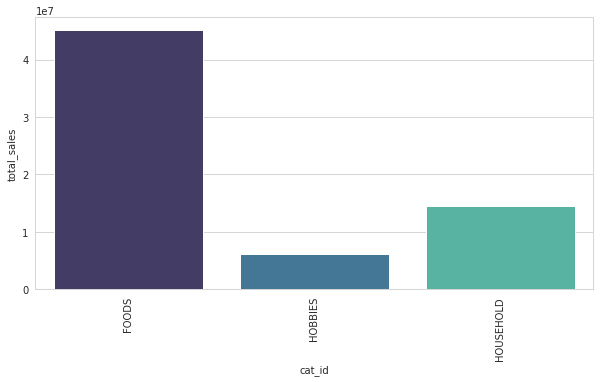

In [18]:
sale_train_cp['total_sales'] = sale_train_cp[d_cols].sum(axis = 1)

# Tính tổng doanh số trên mỗi danh mục.
L = sale_train_cp.groupby(['cat_id'])['total_sales'].sum().reset_index()

# Cài đặt kiểu cho biểu đồ
sns.set_style('whitegrid')
sns.axes_style(style='ticks')

# Khai báo biểu đồ với 1 hàng và 2 cột, kích thước (rộng, cao)
fig, ax = plt.subplots(figsize=(10,5))

# Biểu đồ cột cho từng danh mục.
sns.barplot(x = 'cat_id', y='total_sales', data=L, 
            palette='mako', ax=ax)

# Xoay label của trục x 90 độ.
ax.tick_params(axis='x', rotation=90)

#plt.xticks(rotation=90)
plt.show()

#**Doanh số theo tháng trên mỗi cửa hàng**

In [19]:
store_month_df = sale_train_cp.groupby(['store_id'])[d_cols].sum().T.merge(calenda.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')  
store_month_df.reset_index()
store_month_df.index = pd.DatetimeIndex(store_month_df.index)

store_month_df = store_month_df.resample('MS').sum()  
store_month_df.reset_index()
store_month_df.head()

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,
2011-01-01,11308,8661,13351,4788,7065,10520,8261,6460,6196,11553
2011-02-01,89434,67686,119792,41189,62534,84900,64581,46592,51708,97959
2011-03-01,93468,73964,127344,44902,66890,89902,68370,49747,51113,97867
2011-04-01,91553,72803,122428,44220,66435,87683,66563,46898,47651,91479
2011-05-01,87988,68305,120711,44562,67920,86128,67572,45269,45487,85620


In [20]:
from plotly.subplots import make_subplots
def plotly_time_subplot_rolling_month(df, text, start_col=0, end_col=4):
    fig = make_subplots(rows=1, cols=3, horizontal_spacing= 0.04)
    for c in df.columns[0:]:  # duyệt qua 10 cửa hàng
      n = lambda x : 1 if x == 'C' else (2 if x == 'T' else 3)
      a = n(c[0])

      fig.append_trace(go.Scatter(x=df.index, 
                              y=df[c],
                              mode='lines',
                              name = c), row=1, col=int(a))
    
    fig.update_layout( title = text , template = 'plotly_white',
        height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    


    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()

In [21]:
plotly_time_subplot_rolling_month(store_month_df, 'Doanh số của các cửa hàng theo tháng', start_col = 0, end_col = 4)

#**Doanh số hàng tháng ở các Bộ phận khác nhau của ba Tiểu bang**

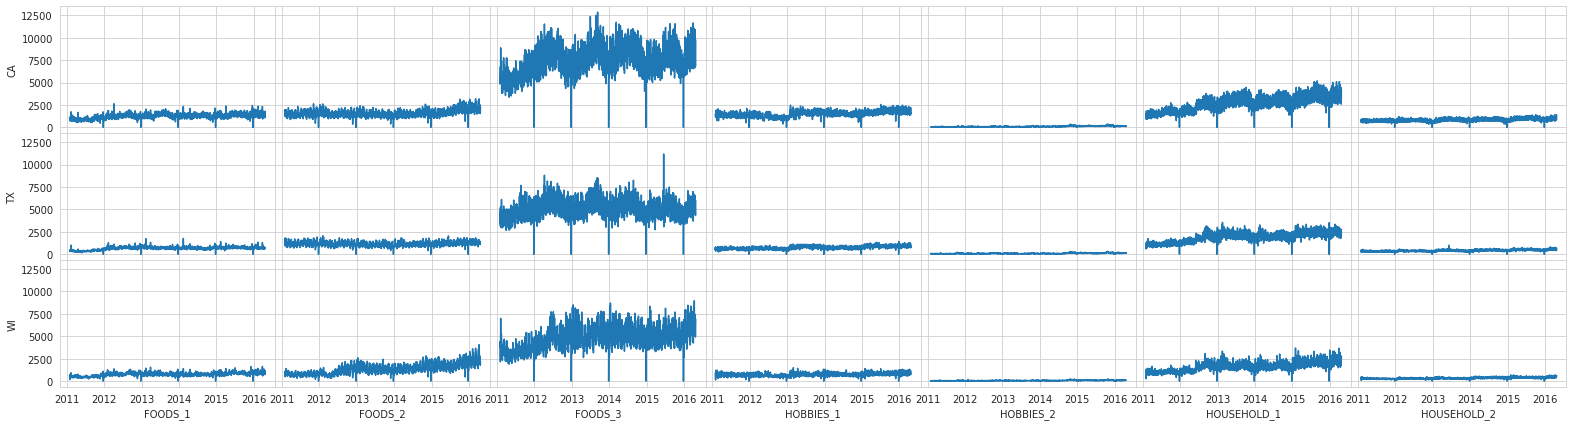

In [22]:
F = sale_train.groupby(['state_id','dept_id'])[(sale_train.columns)[6:]].sum() # Tạo dữ liệu nhóm theo state_id và dept_id
fig, ax = plt.subplots(3, 7, sharey=True,sharex=True,figsize = (27,7))
for i in range(3): # Duyệt qua 3 tiểu bang
    for j in range(7): # Duyệt qua 7 loại hàng hóa.
        k = (7*i)+(j) # tính ra dòng hiện tại.
        ax[i,j].plot(F.iloc[k,1:-1])
        ax[i,j].grid(b=True,axis='y')
        ax[i,j].set(xlabel = F.index[k][1], ylabel = F.index[k][0])  # cột 0 là state_id, cột 1 là dept_id
for a in ax.flat:
    a.label_outer() # chỉ hiển thị label ở biểu đồ lớn, không hiển thị trong biểu đồ con.
fig.subplots_adjust( hspace = 0.0,wspace=0.0)
plt.show()

#**Tổng doanh số với tính năng Làm mịn phù hợp**

In [23]:
sale_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,2011-01-29,2011-01-30,2011-01-31,2011-02-01,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [24]:
F = sale_train.drop(labels=[datetime.date(2011, 12, 25),datetime.date(2012, 12, 25), datetime.date(2013, 12, 25),datetime.date(2014, 12, 25),datetime.date(2015, 12, 25)],axis=1)
# xóa cột ngày 25 tháng 12 của các năm.
F.head()

,id,item_id,dept_id,cat_id,store_id,state_id,2011-01-29,2011-01-30,2011-01-31,2011-02-01,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


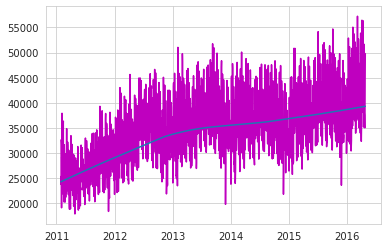

In [25]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
S = F.iloc[:,6:].sum()
z = lowess(S.values, range(S.shape[0]))

plt.plot(S,color='m')
plt.plot(pd.Series(z[:,1],S.index))

#**Tính thời vụ trong tồn kho**

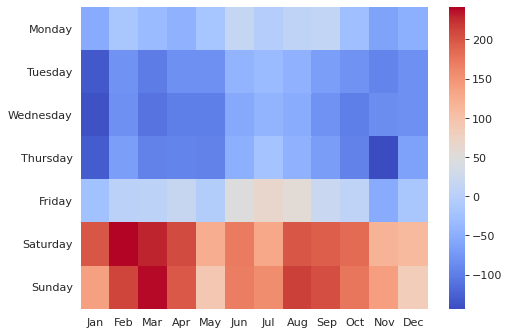

In [26]:
M = F.iloc[:,6:].sum() # tạo dữ liệu cần dùng bằng cách trích dữ liệu từ dataframe F. lấy tất cả các dòng và lấy từ cột 6 đến hết.
z = lowess(M, range(M.shape[0]))
Z = M.values - z[:,1]

A = (pd.DataFrame(data=Z,index=M.index)).T

A = A.groupby(A.columns.map(lambda x : str(x.weekday())+'-'+str(x.month)),axis=1).sum() # Tạo dữ liệu group theo ngày trong tuần và tháng.
H = np.zeros((7,12)) # khởi tạo 1 sensor với giá trị 0
for i in range(7): # chỉ mục (index) ngày trong tuần [0, 7]
    for j in range(12): # chỉ mục(index) tháng [0, 12]
        H[i,j] = A[str(i)+'-'+str(j+1)]//1000
       
import seaborn as sns
plt.figure(None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(H,cmap='coolwarm',xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],yticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday' ])
plt.show()

In [27]:
sales_cal_df = sale_train_cp.groupby(['id'])[d_cols].sum().T.merge(calenda.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

sales_cal_df.head()                                                                   

,FOODS_1_001_CA_1_validation,FOODS_1_001_CA_2_validation,FOODS_1_001_CA_3_validation,FOODS_1_001_CA_4_validation,FOODS_1_001_TX_1_validation,FOODS_1_001_TX_2_validation,FOODS_1_001_TX_3_validation,FOODS_1_001_WI_1_validation,FOODS_1_001_WI_2_validation,FOODS_1_001_WI_3_validation,...,HOUSEHOLD_2_516_CA_1_validation,HOUSEHOLD_2_516_CA_2_validation,HOUSEHOLD_2_516_CA_3_validation,HOUSEHOLD_2_516_CA_4_validation,HOUSEHOLD_2_516_TX_1_validation,HOUSEHOLD_2_516_TX_2_validation,HOUSEHOLD_2_516_TX_3_validation,HOUSEHOLD_2_516_WI_1_validation,HOUSEHOLD_2_516_WI_2_validation,HOUSEHOLD_2_516_WI_3_validation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,3,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
2011-01-30,0,0,2,1,1,0,0,2,0,0,...,1,0,1,0,0,1,0,0,0,1
2011-01-31,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-02-01,1,0,1,1,0,2,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
2011-02-02,4,1,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [28]:
sales_cal_df = sales_cal_df.reset_index()
sales_cal_df['date'] = pd.to_datetime(sales_cal_df['date'])
sales_cal_df['month'] = sales_cal_df.date.dt.month
sales_cal_df['day'] = sales_cal_df.date.dt.day
sales_cal_df['year'] = sales_cal_df.date.dt.year
sales_cal_df['weekday'] = sales_cal_df.date.dt.weekday
sales_cal_df['weekday'] = sales_cal_df.date.dt.day_name()
sales_cal_df.head(2)

,date,FOODS_1_001_CA_1_validation,FOODS_1_001_CA_2_validation,FOODS_1_001_CA_3_validation,FOODS_1_001_CA_4_validation,FOODS_1_001_TX_1_validation,FOODS_1_001_TX_2_validation,FOODS_1_001_TX_3_validation,FOODS_1_001_WI_1_validation,FOODS_1_001_WI_2_validation,...,HOUSEHOLD_2_516_TX_1_validation,HOUSEHOLD_2_516_TX_2_validation,HOUSEHOLD_2_516_TX_3_validation,HOUSEHOLD_2_516_WI_1_validation,HOUSEHOLD_2_516_WI_2_validation,HOUSEHOLD_2_516_WI_3_validation,month,day,year,weekday
0,2011-01-29,3,2,1,0,0,0,0,0,0,...,0,0,2,0,0,0,1,29,2011,Saturday
1,2011-01-30,0,0,2,1,1,0,0,2,0,...,0,1,0,0,0,1,1,30,2011,Sunday


#**Bán hàng theo thời vụ tại từng tiểu bang**

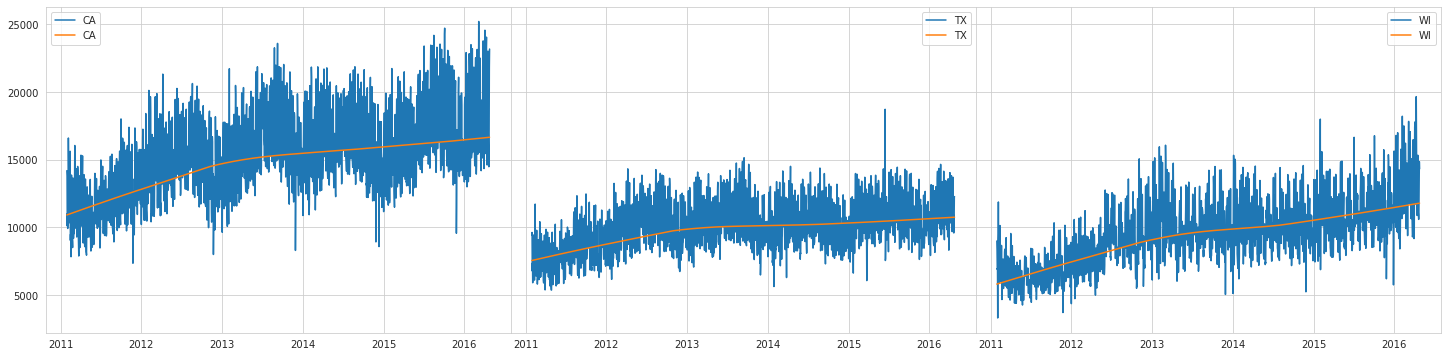

In [29]:
M = F.groupby(['state_id'])[(F.columns)[6:]].sum() # tạo dữ liệu cần dùng group theo state_id

fig, ax = plt.subplots(1, 3, sharey=True, figsize = (25,6)) # khởi tạo biểu đồ với 3 biểu đồ con.

for i in range(3): # lặp qua 3 tiểu bang để vẽ biểu đồ con tương ứng.
    ax[i].plot(M.iloc[i,:],label=M.index[i]) # đường màu xanh (dữ liệu gốc)
    z = lowess(M.iloc[i,:].values, range(M.shape[1])) # đường màu vàng (dữ liệu đã được làm mịn)
    ax[i].plot(pd.Series(z[:,1],M.columns),label=M.index[i])
    ax[i].grid(b=True,axis='y') # vẽ lưới (các đường ngang) trên biểu đồ.
    ax[i].legend(loc='best')

fig.subplots_adjust( wspace=0.0) # khoảng cách giữa các biểu đồ con.
plt.show()


#**Thời vụ hàng tuần**

In [30]:
mean_sales = F.iloc[:,6:].sum().mean() # tính giá trị trung bình
mean_sales

34431.515199161426

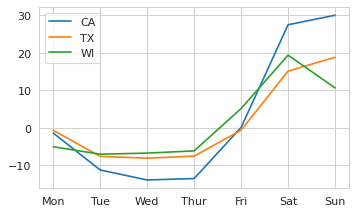

In [31]:
A = M
for i in range(3):
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    A.iloc[i,:] = M.iloc[i,:] - z[:,1]  
     
A = A / mean_sales # chia các phần tử của ma trận cho giá trị trung bình.

A = A.groupby(A.columns.map(lambda x : str(x.weekday())),axis=1).sum() # tạo dữ liệu group theo ngày trong tuần.
plt.figure(num=None, figsize=(5, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(A.iloc[i,:],label=A.index[i])
    plt.xticks(range(0,7),['Mon', 'Tue', 'Wed', 'Thur', 'Fri','Sat','Sun' ])
    plt.legend(loc='best')
plt.show()

#**Thời vụ hàng tháng**

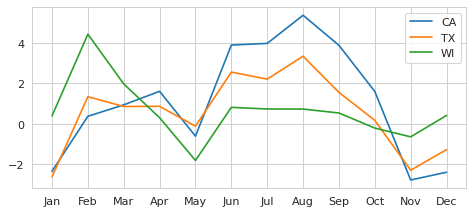

In [32]:
A = M
for i in range(3):
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    A.iloc[i,:] = M.iloc[i,:] - z[:,1]
A = A/mean_sales
A = A.groupby(A.columns.map(lambda x : (x.month)),axis=1).sum()
plt.figure(num=None, figsize=(7,3), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(A.iloc[i,:],label=A.index[i])
    plt.legend(loc='best')
    plt.xticks(range(1,13),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

#**Thời vụ hàng tuần và hàng tháng theo tiểu bang và danh mục**

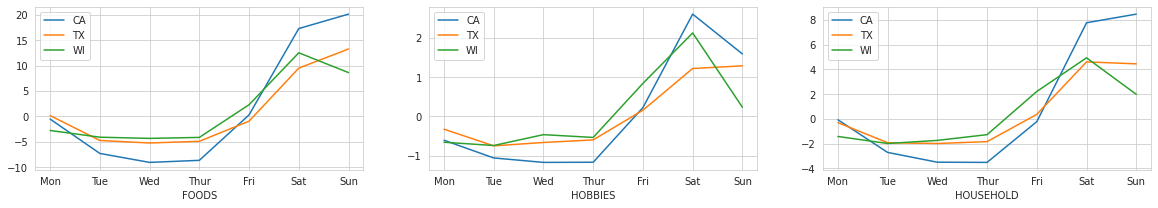

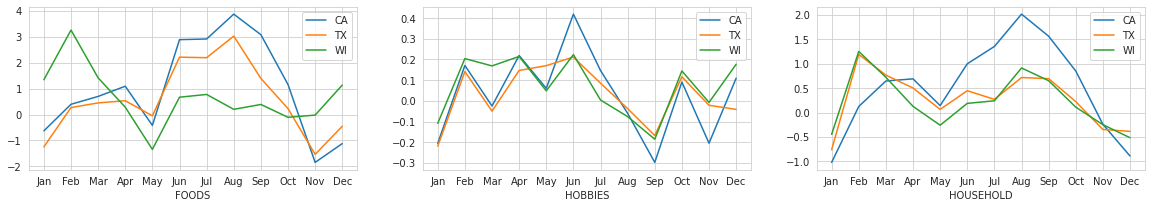

In [33]:
M = F.groupby(['cat_id','state_id'])[(F.columns)[6:]].sum()
A = M
for i in range(9):
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    A.iloc[i,:] = M.iloc[i,:] - z[:,1]
G = A/mean_sales
A = G.groupby(G.columns.map(lambda x : str(x.weekday())),axis=1).sum()
fig, ax = plt.subplots(1,3,figsize = (20,3),sharex=True)
for i in range(9):
    ax[(i//3)].plot(A.iloc[i,:],label=A.index[i][1])
    ax[(i//3)].legend(loc='best')
    ax[i//3].set(xlabel = A.index[i][0])
plt.xticks(range(0,7),['Mon', 'Tue', 'Wed', 'Thur', 'Fri','Sat','Sun' ])
plt.show()

B = G.groupby(G.columns.map(lambda x : x.month),axis=1).sum()
fig, ax = plt.subplots(1,3,figsize = (20,3), sharex=True)
for i in range(9):
    ax[(i//3)].plot(B.iloc[i,:],label=B.index[i][1])
    ax[(i//3)].legend(loc='best')
    ax[i//3].set(xlabel = B.index[i][0])
plt.xticks(range(1,13),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

**Ngày có sự kiện so với ngày không có sự kiện**

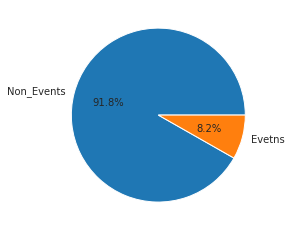

In [34]:
Non_events = calenda.date.count() - calenda.event_name_1.count()
Events = calenda.event_name_1.count()
pd.Series([Non_events,Events], ['Non_Events',"Evetns"],name="").plot.pie(autopct='%1.1f%%')
plt.show()

**Số lượng loại sự kiện liên quan**

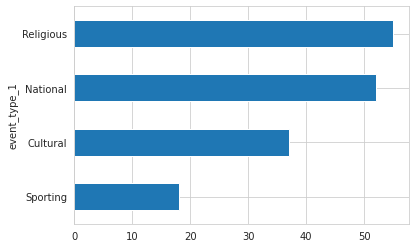

In [35]:
calenda.groupby(['event_type_1']).count().iloc[:,1].sort_values(ascending=True).plot.barh()
plt.show()

**Ngày SNAP trong tháng ở các tiểu bang khác nhau**

In [36]:
'''import matplotlib as mpl
import calmap

# Import Data
df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/yahoo.csv", parse_dates=['date'])
df.set_index('date', inplace=True)

# Plot
plt.figure(figsize=(16,10), dpi= 80)
calmap.calendarplot(df['2014']['VIX.Close'], fig_kws={'figsize': (16,10)}, yearlabel_kws={'color':'black', 'fontsize':14}, subplot_kws={'title':'Yahoo Stock Prices'})
plt.show()'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Settings
years = [2012] 
weeks = [1, 2, 3, 4, 5, 6]
days = ['M', 'T', 'W', 'T', 'F', 'S', 'S']
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
               'September', 'October', 'November', 'December']

def generate_data():
    idx = pd.date_range('2012-01-01', periods=182, freq='D')
    return pd.Series(range(len(idx)), index=idx)


def split_months(df, year):
    """
    Take a df, slice by year, and produce a list of months,
    where each month is a 2D array in the shape of the calendar
    :param df: dataframe or series
    :return: matrix for daily values and numerals
    """
    df = df[df.index.year == year]


    # Empty matrices
    a = np.empty((6, 7))
    a[:] = np.nan

    day_nums = {m:np.copy(a) for m in range(1,7)}  # matrix for day numbers
    day_vals = {m:np.copy(a) for m in range(1,7)}  # matrix for day values

    # Logic to shape datetimes to matrices in calendar layout
    for d in df.iteritems():  # use iterrows if you have a DataFrame

        day = d[0].day
        month = d[0].month
        col = d[0].dayofweek

        if d[0].is_month_start:
            row = 0

        day_nums[month][row, col] = day  # day number (0-31)
        day_vals[month][row, col] = d[1] # day value (the heatmap data)

        if col == 6:
            row += 1

    return day_nums, day_vals


def create_year_calendar(day_nums, day_vals, X, name):
    fig, ax = plt.subplots(1, 6, figsize=(20, 12))

    for i, axs in enumerate(ax.flat):

        axs.imshow(day_vals[i+1], cmap='viridis', vmin=1, vmax=365)  # heatmap
        axs.set_title(month_names[i])

        # Labels
        axs.set_xticks(np.arange(len(days)))
        axs.set_xticklabels(days, fontsize=10, fontweight='bold', color='#555555')
        axs.set_yticklabels([])

        # Tick marks
        axs.tick_params(axis=u'both', which=u'both', length=0)  # remove tick marks
        axs.xaxis.tick_top()

        # Modify tick locations for proper grid placement
        axs.set_xticks(np.arange(-.5, 6, 1), minor=True)
        axs.set_yticks(np.arange(-.5, 6, 1), minor=True)
        axs.grid(which='minor', color='w', linestyle='-', linewidth=2.1)

        # Despine
        for edge in ['left', 'right', 'bottom', 'top']:
            axs.spines[edge].set_color('#FFFFFF')

        # Annotate
        for w in range(len(weeks)):
            for d in range(len(days)):
                day_num = day_nums[i+1][w, d]
                if not np.isnan(day_num):    # Value label
                    axs.text(d, w, f"{day_num:0.0f}",
                             ha="center", va="center",
                             fontsize=15, color="k", alpha=0.8)
                    patch_coords = ((d - 0.5, w - 0.5),
                                    (d - 0.5, w + 0.5),
                                    (d + 0.5, w + 0.5),
                                    (d + 0.5, w - 0.5))
                    if datetime.datetime.strptime(str(years[0])+'-'+str(i+1)+'-'+str(int(day_num)), '%Y-%m-%d').date().strftime('%Y-%m-%d') in X:
                        square = Polygon(patch_coords, fc='#FF4500')  #FF4500
                        axs.add_artist(square)
                    else:
                        square = Polygon(patch_coords, fc='#DDDDDD')
                        axs.add_artist(square)

    # Final adjustments
    fig.suptitle(name + ' 2012', fontsize=20)
    plt.subplots_adjust(left=0.04, right=0.96, top=1, bottom=0.65)
    plt.show()

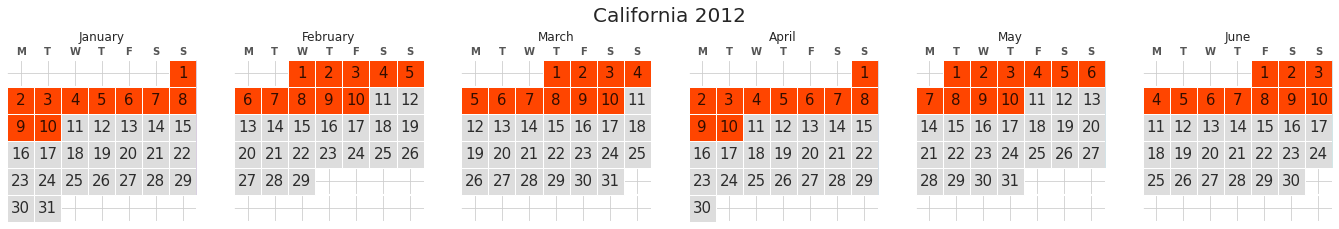

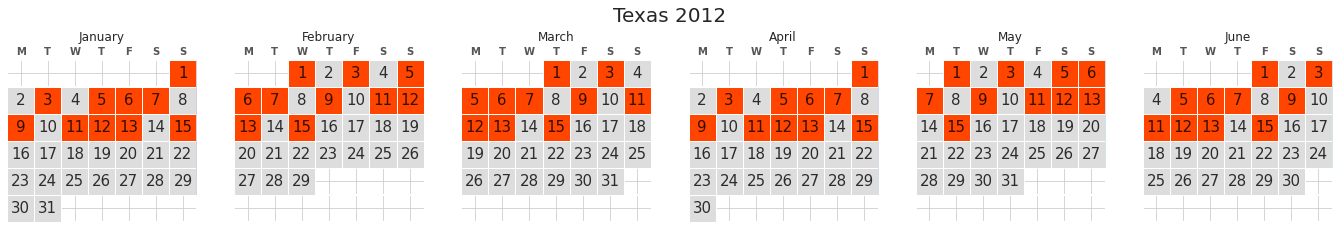

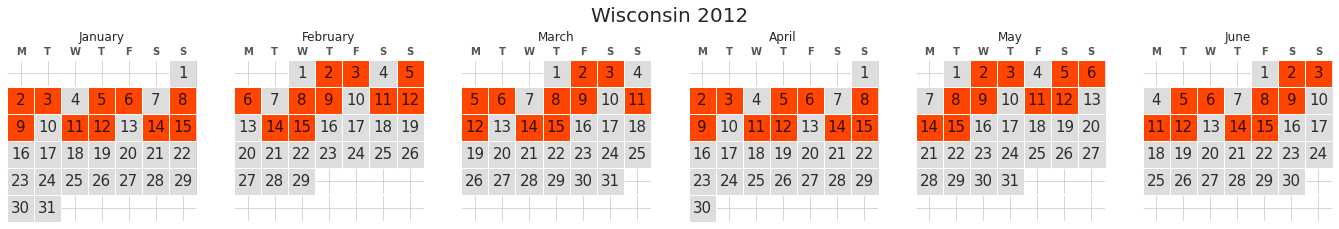

In [37]:
CA = calenda.date[calenda.snap_CA == 1].values
TX = calenda.date[calenda.snap_TX == 1].values
WI = calenda.date[calenda.snap_WI == 1].values
df = generate_data()
day_nums, day_vals = split_months(df,2012)
create_year_calendar(day_nums, day_vals,CA,'California')
create_year_calendar(day_nums, day_vals,TX,'Texas')
create_year_calendar(day_nums, day_vals,WI,'Wisconsin')

**Phân bổ giá mặt hàng của các nhóm hàng hóa khác nhau của ba tiểu bang**

In [38]:
A=sell_prices.groupby([sell_prices.store_id.str.slice(0,-2),sell_prices.item_id.str.slice(0,-4)])
B = []
for name, group in A:
    B.append(name)

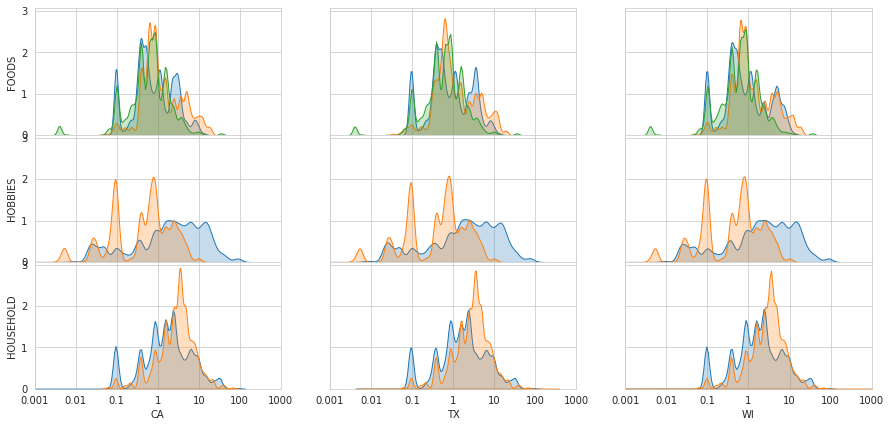

In [39]:
import seaborn as sns
fig, ax = plt.subplots(3,3,sharey=True,sharex=True, figsize=(15,7))
k=0
for j in range(3):
    for i in range(0,1):
        sns.kdeplot(np.log10(A.get_group(B[k])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        sns.kdeplot(np.log10(A.get_group(B[k+1])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        sns.kdeplot(np.log10(A.get_group(B[k+2])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        ax[i,j].grid(b=True,axis='y')
        ax[i,j].set(xlabel = 'CA' if j==0 else('TX' if j==1 else'WI'), ylabel ="FOODS")
    for i in range(1,2):
        sns.kdeplot(np.log10(A.get_group(B[k+3])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        sns.kdeplot(np.log10(A.get_group(B[k+4])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        ax[i,j].grid(b=True,axis='y')
        ax[i,j].set(xlabel = 'CA' if j==0 else('TX' if j==1 else'WI'),ylabel = "HOBBIES")
    for i in range(2,3):
        sns.kdeplot(np.log10(A.get_group(B[k+5])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        sns.kdeplot(np.log10(A.get_group(B[k+6])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        ax[i,j].grid(b=True,axis='y')
        ax[i,j].set(xlabel = 'CA' if j==0 else('TX' if j==1 else'WI'),ylabel ="HOUSEHOLD")
    k=k+7
fig.canvas.draw()
loc,labels = plt.xticks()
for ax in ax.flat:
    ax.label_outer()
    ax.set_xlim(-1,2)
    ax.set_xticklabels([10 ** int(i.get_text().replace(u'\u2212', '-')) for i in labels])
fig.subplots_adjust( hspace = 0.0,wspace=0.2)
plt.show()

**Phân bổ giá mặt hàng của các nhóm hàng hóa khác nhau mỗi năm**

In [40]:
A=sell_prices.groupby([sell_prices.item_id.str.slice(0,-4),sell_prices.wm_yr_wk//100 + 1900])['sell_price']
n = []
for name,group in A:
    n.append(name)

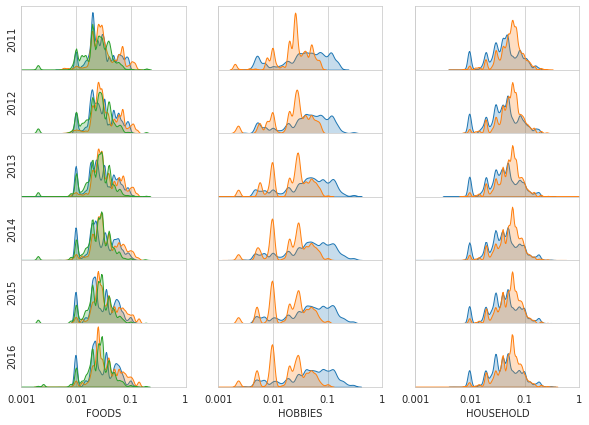

In [41]:
import seaborn as sns
fig, ax = plt.subplots(6,3,sharey=True,sharex=True, figsize=(10,7))

for i in n:
    j = 0 if i[0][:-2]=='FOODS' else (1 if i[0][:-2]=='HOBBIES' else 2)
    k = i[1] - 2011
    sns.kdeplot(np.log10(A.get_group(i)),legend=False,bw=0.1,shade=True,ax=ax[k,j])
    ax[k,j].set(xlabel = i[0][:-2], ylabel =k+2011)
fig.canvas.draw()
loc,labels = plt.xticks()
for ax in ax.flat:
    ax.label_outer()
    ax.set_xlim(-1,2)
    ax.set_xticklabels([10 ** int(i.get_text().replace(u'\u2212', '-')) for i in labels])
plt.yticks([], [])
fig.subplots_adjust( hspace = 0.0,wspace=0.2)
plt.show()

#**Doanh số cho mỗi danh mục trong các ngày có Sự kiện và Không có sự kiện**

In [42]:
c = [datetime.date(2011, 12, 25),datetime.date(2012, 12, 25), datetime.date(2013, 12, 25),datetime.date(2014, 12, 25),datetime.date(2015, 12, 25)]
F = sale_train.drop(labels=c,axis=1)
event_dates = calenda[pd.notnull(calenda['event_name_1'])]['date'] 
event_dates = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in event_dates.values]

for i in c:
    event_dates.remove(i)
event_sales = F[['id','dept_id','cat_id', 'store_id', 'state_id']+event_dates[:-8]]
nevent_sales = F[F.drop(columns=event_dates[:-8]).columns]

In [43]:
N3 = []
L1 = []
L2 = []
L3 = []
means = []
e = event_sales.groupby(['cat_id']).sum()
ne = nevent_sales.groupby(['cat_id']).sum()
t = F.groupby(['cat_id']).sum()
means = t.mean(axis=1)
for i in range(3):
    n1 = lowess(e.iloc[i,:].values, range(e.shape[1]),frac=0.4)
    n2 = lowess(ne.iloc[i,:].values, range(ne.shape[1]),frac=0.4)
    n3 = lowess(t.iloc[i,:].values, range(t.shape[1]),frac=0.4)
    L1.append(n1[:,1])
    L2.append(n2[:,1])
    L3.append(n3[:,1])
    n3 = (t.iloc[i,:] - n3[:,1]) /(means[i])
    N3.append(n3)
N3 = pd.DataFrame(N3,columns = t.columns)
L1 = pd.DataFrame(L1,columns = e.columns)
L2 = pd.DataFrame(L2,columns = ne.columns)
L3 = pd.DataFrame(L3,columns = t.columns)

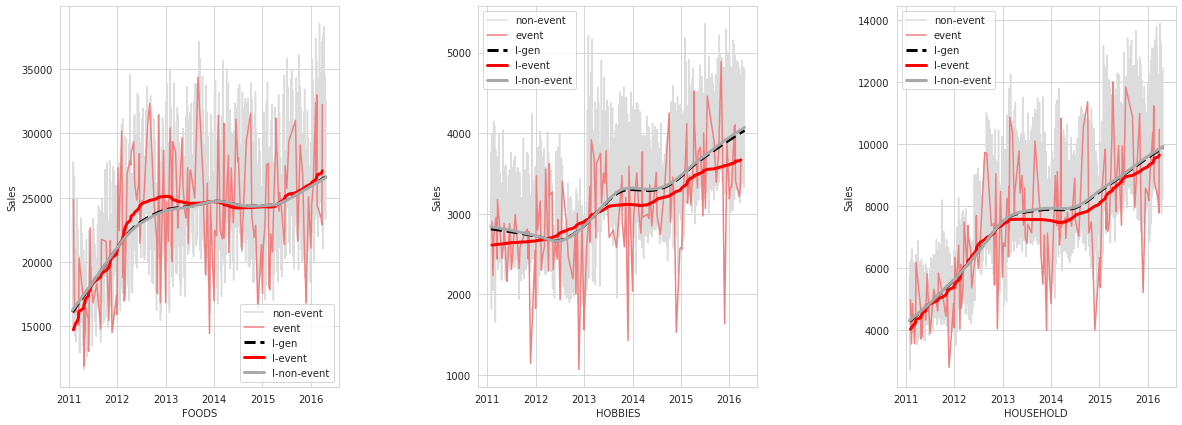

In [44]:
fig, ax = plt.subplots(1,3, figsize=(20,7))
for j in range(3):
    ax[j].plot(ne.iloc[j,:] ,color='gainsboro', label = 'non-event')
    ax[j].plot(e.iloc[j,:] ,color='lightcoral',label = 'event') 
    ax[j].plot(L3.iloc[j,:] ,color = 'black', linestyle= 'dashed',label = 'l-gen',linewidth=3) 
    ax[j].plot(L1.iloc[j,:] ,color='red',label = 'l-event',linewidth=3)   
    ax[j].plot(L2.iloc[j,:] ,color = 'darkgray',label = 'l-non-event',linewidth=3) 
    ax[j].grid(b=True,axis='y')
    ax[j].legend(loc='best')
    ax[j].set(xlabel = t.index[j] ,ylabel = 'Sales')

fig.subplots_adjust( hspace = 0.0,wspace=0.5)
plt.show()

In [45]:
N1 = N3[event_dates[:-8]].T.assign(Event='True')
N2 = N3[N3.drop(columns=event_dates[:-8]).columns].T.assign(Event='False')
cdf = pd.concat([N1,N2])
mdf = pd.melt(cdf, id_vars=['Event'], var_name=['Letter'])

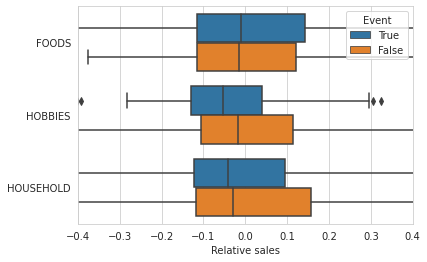

In [46]:
a = sns.boxplot(x="value", y="Letter", hue="Event", data=mdf, orient='h') 

a.set(xlabel="Relative sales",ylabel='')
a.set_xlim(-0.4, 0.4)
plt.show()

In [47]:
N3 = []
means = []
t = F.groupby(['cat_id']).sum()
means = t.mean(axis=1)
for i in range(3):
    n3 = lowess(t.iloc[i,:].values, range(t.shape[1]),frac=0.5)
    n3 = (t.iloc[i,:] - n3[:,1]) /(means[i])
    N3.append(n3)
N3 = pd.DataFrame(N3,columns = t.columns)

c = [datetime.date(2011, 12, 25),datetime.date(2012, 12, 25), datetime.date(2013, 12, 25),datetime.date(2014, 12, 25),datetime.date(2015, 12, 25)]
F = sale_train.drop(labels=c,axis=1)
event_dates = calenda[pd.notnull(calenda['event_name_1'])][['date','event_type_1']] 
event_dates['date'] = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in event_dates['date']]

for i in c:
    event_dates = event_dates[event_dates['date'] != i]


s = N3.T
s.reset_index(drop=False, inplace=True)
s.rename(columns = {'index':'date'},inplace=True)
s = pd.merge(left=event_dates, right=s, how='left', left_on='date', right_on='date')

s = s.groupby(['event_type_1']).median()
s.reset_index(drop=False, inplace=True)
s = s.melt(id_vars=['event_type_1'], value_vars=s.columns[1:])

[Text(0, 0.5, ''), Text(0.5, 0, 'Median sales')]

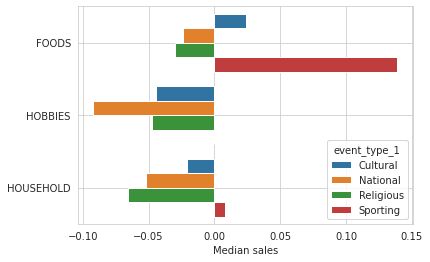

In [48]:
a=sns.barplot(x=s.value,y=s.variable,hue=s.event_type_1)
a.grid(b=True,axis='y')
a.set(xlabel="Median sales",ylabel='')

# **Doanh số ở các tiểu bang khác nhau trong các ngày có sự kiện và không có sự kiện**

In [49]:
c = [datetime.date(2011, 12, 25),datetime.date(2012, 12, 25), datetime.date(2013, 12, 25),datetime.date(2014, 12, 25),datetime.date(2015, 12, 25)]
F = sale_train.drop(labels=c,axis=1)

event_dates = calenda[pd.notnull(calenda['event_name_1'])]['date'] 

event_dates = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in event_dates.values]

for i in c:
    event_dates.remove(i)
event_sales = F[['id','dept_id','cat_id', 'store_id', 'state_id']+event_dates[:-8]]
nevent_sales = F[F.drop(columns=event_dates[:-8]).columns]

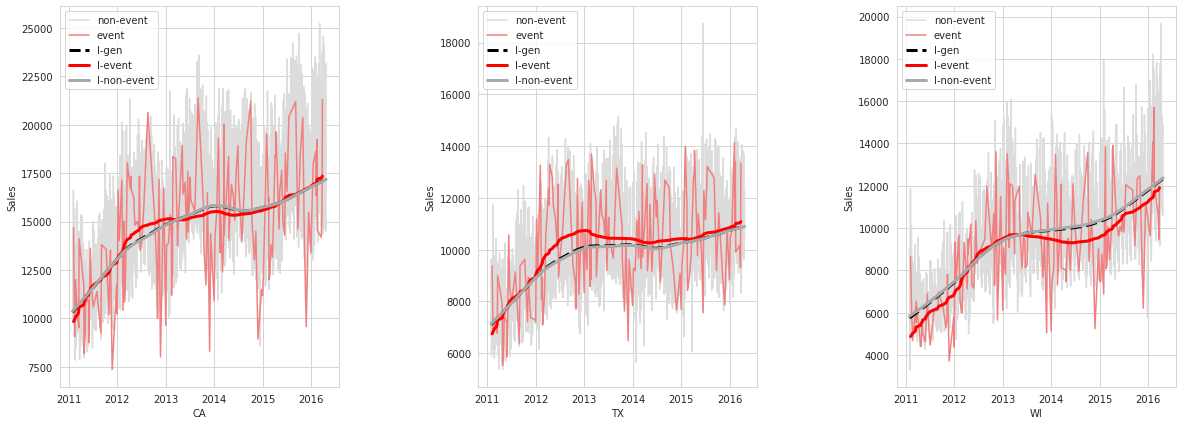

In [50]:
N3 = []
L1 = []
L2 = []
L3 = []
means = []
e = event_sales.groupby(['state_id']).sum()
ne = nevent_sales.groupby(['state_id']).sum()
t = F.groupby(['state_id']).sum()
means = t.mean(axis=1)
for i in range(3):
    n1 = lowess(e.iloc[i,:].values, range(e.shape[1]),frac=0.4)
    n2 = lowess(ne.iloc[i,:].values, range(ne.shape[1]),frac=0.4)
    n3 = lowess(t.iloc[i,:].values, range(t.shape[1]),frac=0.4)
    L1.append(n1[:,1])
    L2.append(n2[:,1])
    L3.append(n3[:,1])
    n3 = (t.iloc[i,:] - n3[:,1]) /(means[i])
    N3.append(n3)
N3 = pd.DataFrame(N3,columns = t.columns)
L1 = pd.DataFrame(L1,columns = e.columns)
L2 = pd.DataFrame(L2,columns = ne.columns)
L3 = pd.DataFrame(L3,columns = t.columns)
fig, ax = plt.subplots(1,3, figsize=(20,7))
for j in range(3):
    ax[j].plot(ne.iloc[j,:] ,color='gainsboro', label = 'non-event')
    ax[j].plot(e.iloc[j,:] ,color='lightcoral',label = 'event') 
    ax[j].plot(L3.iloc[j,:] ,color = 'black', linestyle= 'dashed',label = 'l-gen',linewidth=3) 
    ax[j].plot(L1.iloc[j,:] ,color='red',label = 'l-event',linewidth=3)   
    ax[j].plot(L2.iloc[j,:] ,color = 'darkgray',label = 'l-non-event',linewidth=3) 
    ax[j].grid(b=True,axis='y')
    ax[j].legend(loc='best')
    ax[j].set(xlabel = t.index[j] ,ylabel = 'Sales')

fig.subplots_adjust( hspace = 0.0,wspace=0.5)
plt.show()

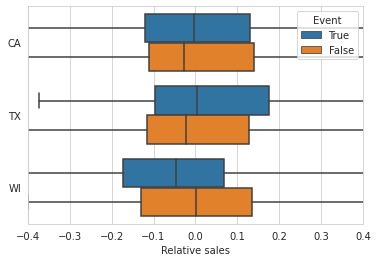

In [51]:
N1 = N3[event_dates[:-8]].T.assign(Event='True')
N2 = N3[N3.drop(columns=event_dates[:-8]).columns].T.assign(Event='False')
cdf = pd.concat([N1,N2])
mdf = pd.melt(cdf, id_vars=['Event'], var_name=['Letter'])
a = sns.boxplot(x="value", y="Letter", hue="Event", data=mdf, orient='h') 

a.set(xlabel="Relative sales",ylabel='')
a.set_xlim(-0.4, 0.4)
plt.show()

[Text(0, 0.5, ''), Text(0.5, 0, 'Median sales')]

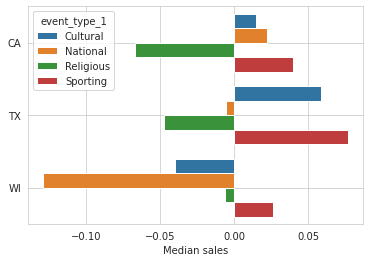

In [52]:
N3 = []
means = []
t = F.groupby(['state_id']).sum()
means = t.mean(axis=1)
for i in range(3):
    n3 = lowess(t.iloc[i,:].values, range(t.shape[1]),frac=0.5)
    n3 = (t.iloc[i,:] - n3[:,1]) /(means[i])
    N3.append(n3)
N3 = pd.DataFrame(N3,columns = t.columns)

event_dates = calenda[pd.notnull(calenda['event_name_1'])][['date','event_type_1']] 
event_dates['date'] = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in event_dates['date'].values]
for i in c:
    event_dates = event_dates[event_dates['date'] != i]
event_dates = event_dates.iloc[:-8,:]

s = N3.T
s.reset_index(drop=False, inplace=True)
s.rename(columns = {'index':'date'},inplace=True)
s = pd.merge(left=event_dates, right=s, how='left', left_on='date', right_on='date')

s = s.groupby(['event_type_1']).median()
s.reset_index(drop=False, inplace=True)
s = s.melt(id_vars=['event_type_1'], value_vars=s.columns[1:])


a=sns.barplot(x=s.value,y=s.variable,hue=s.event_type_1)
a.grid(b=True,axis='y')
a.set(xlabel="Median sales",ylabel='')

# **Doanh số tại mỗi tiểu bang vào những ngày SNAP so với những ngày không SNAP**

In [53]:
c = [datetime.date(2011, 12, 25),datetime.date(2012, 12, 25), datetime.date(2013, 12, 25),datetime.date(2014, 12, 25),datetime.date(2015, 12, 25)]
F = sale_train.drop(labels=c,axis=1)
F = F.groupby(['state_id']).sum()
CA_snap = calenda.date[calenda.snap_CA == 1].values
TX_snap = calenda.date[calenda.snap_TX == 1].values
WI_snap = calenda.date[calenda.snap_WI == 1].values
CA_snap = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in CA_snap]
TX_snap = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in TX_snap]
WI_snap = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in WI_snap]

CA_snap_sales = F[CA_snap[:-20]].iloc[0,:]
TX_snap_sales = F[TX_snap[:-20]].iloc[1,:]
WI_snap_sales = F[WI_snap[:-20]].iloc[2,:]

CA_nsnap_sales = F[F.drop(columns=CA_snap[:-20]).columns].iloc[0,:]
TX_nsnap_sales = F[F.drop(columns=TX_snap[:-20]).columns].iloc[1,:]
WI_nsnap_sales = F[F.drop(columns=WI_snap[:-20]).columns].iloc[2,:]

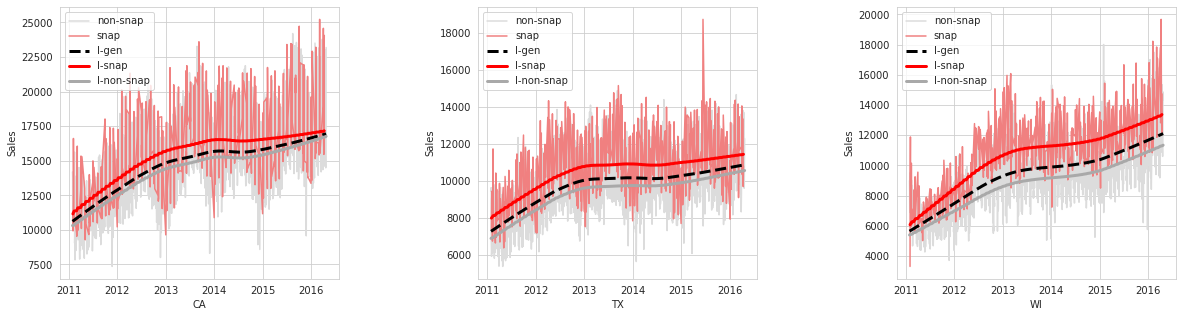

In [54]:
N3 = []
L1 = []
L2 = []
L3 = []
means = []
e = [CA_snap_sales,TX_snap_sales,WI_snap_sales]
ne = [CA_nsnap_sales,TX_nsnap_sales,WI_nsnap_sales]
t = F
means = t.mean(axis=1)
for i in range(3):
    n1 = lowess(e[i].values, range(len(e[i])),frac=0.5)
    n2 = lowess(ne[i].values, range(len(ne[i])),frac=0.5)
    nn3 = lowess(t.iloc[i,:].values, range(t.shape[1]),frac=0.5)
    n1 = pd.Series(n1[:,1],e[i].index)
    n2 = pd.Series(n2[:,1],ne[i].index)
    n3 = pd.Series(nn3[:,1],t.columns)
    L1.append(n1)
    L2.append(n2)
    L3.append(n3)
    n3 = (t.iloc[i,:] - nn3[:,1]) /(means[i])
    N3.append(n3)
N3 = pd.DataFrame(N3,columns = t.columns)

fig, ax = plt.subplots(1,3, figsize=(20,5))
for j in range(3):
    ax[j].plot(ne[j] ,color='gainsboro', label = 'non-snap')
    ax[j].plot(e[j],color='lightcoral',label = 'snap') 
    ax[j].plot(L3[j] ,color = 'black', linestyle= 'dashed',label = 'l-gen',linewidth=3) 
    ax[j].plot(L1[j] ,color='red',label = 'l-snap',linewidth=3)   
    ax[j].plot(L2[j] ,color = 'darkgray',label = 'l-non-snap',linewidth=3) 
    ax[j].grid(b=True,axis='y')
    ax[j].legend(loc='best')
    ax[j].set(xlabel = t.index[j] ,ylabel = 'Sales')

fig.subplots_adjust( hspace = 0.0,wspace=0.5)
plt.show()

# **Tỷ lệ phần trăm Doanh số hàng ngày vào các ngày SNAP và Không phải SNAP**

In [55]:
perc = []
for i in range(3):
    a = e[i].sum()/(1908/3)
    b = ne[i].sum()/(2*1908/3)
    perc.append([a*100/(a+b), b*100/(a+b)])

perc = pd.DataFrame(perc,index=["CA","TX","WI"],columns=["SNAP","NON_SNAP"])
perc.reset_index(drop=False, inplace=True)
s = perc.melt(id_vars=['index'], value_vars=perc.columns[1:])
s = s.sort_values(by='index',ignore_index=True)

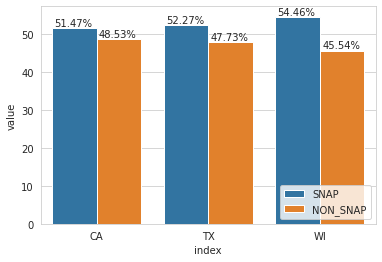

In [56]:
ax = sns.barplot(y=s.value,hue=s.variable,x=s['index'])
ax.legend(loc = 'lower right')
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height()+'%', xy=(p.get_x()+p.get_width()/2,p.get_height()),
            xytext=(-20,5), textcoords='offset points', ha="left", va="center")

# **Tỷ lệ phần trăm Doanh số hàng ngày trên các ngày SNAP và Không phải SNAP trên mỗi danh mục**

In [57]:
F  = sale_train.groupby(['state_id','cat_id']).sum()
F.reset_index(drop=False, inplace=True)
l = [CA_snap[:-20],TX_snap[:-20],WI_snap[:-20]]

t = []
for i in range(9):
    t.append((F['state_id'][i],F['cat_id'][i]))
    
a=[]
b = []
perc = []
for i in range(9):
    a.append(F[l[i//3]].loc[i,:].sum()/(1908/3))
    b.append(F[F.drop(columns=l[i//3]).columns].iloc[i,3:].sum()/(2*1908/3))
    perc.append([a[i]*100/(a[i]+b[i]), b[i]*100/(a[i]+b[i])])
perc = pd.DataFrame(perc,index=t,columns=["SNAP","NON_SNAP"])
perc.reset_index(drop=False, inplace=True)
s = perc.melt(id_vars=['index'], value_vars=perc.columns[1:])
s = s.sort_values(by='index',ignore_index=True)

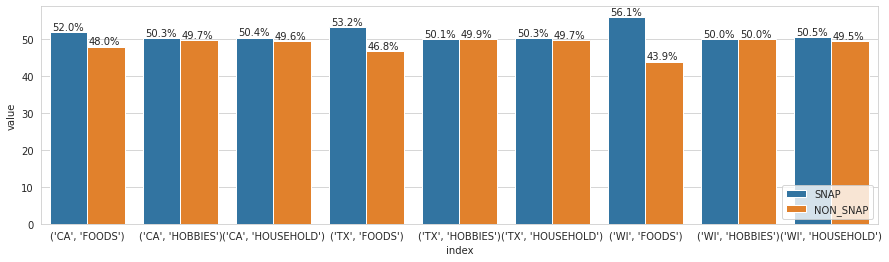

In [58]:
fig, ax = plt.subplots(figsize=(15,4))
ax = sns.barplot(y=s.value,hue=s.variable,x=s['index'])
ax.legend(loc = 'lower right')

for p in ax.patches:
    ax.annotate("%.1f" % p.get_height()+'%', xy=(p.get_x()+p.get_width()/2,p.get_height()),
            xytext=(-17,5), textcoords='offset points', ha="left", va="center")

# **Tác động của SNAP đối với doanh số bán hàng thực phẩm ở CA**
Doanh số bán hàng tương đối vào các ngày SNAP - Doanh số bán hàng tương đối vào các ngày khác
Màu đỏ - hiệu ứng SNAP cao và Màu xanh lam - hiệu ứng SNAP thấp

In [59]:
z = F.drop(labels=c,axis=1).iloc[0,2:]
n1 = lowess(z.values, range(1908),frac=0.5)
rel_sales = (z.values - n1[:,1]) / z.mean()
rel_sales = pd.Series(rel_sales,z.index)

rel_sales1 = rel_sales[CA_snap[:-20]]
rel_sales2 = rel_sales.drop(labels = CA_snap[:-20])

a = rel_sales1.groupby(rel_sales1.index.map(lambda x : str(x.weekday())+'-'+str(x.month))).sum()
b = rel_sales2.groupby(rel_sales2.index.map(lambda x : str(x.weekday())+'-'+str(x.month))).sum()

H = np.zeros((7,12))
for i in range(7):
    for j in range(12):
        H[i,j] = a[str(i)+'-'+str(j+1)] - b[str(i)+'-'+str(j+1)]

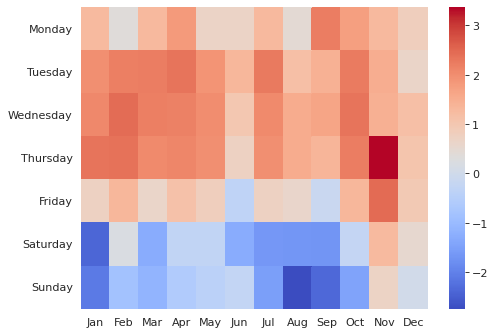

In [60]:
import seaborn as sns
plt.figure(None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(H,cmap='coolwarm',xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],yticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday' ])
plt.show()

# **Doanh số cho Ba mặt hàng ngẫu nhiên vào giữa năm 2015 với điểm Màu đen là Sự kiện và Nền màu xám đại diện cho ngày SNAP**

In [61]:
x = sale_train[sale_train['id'].isin(["FOODS_2_092_CA_1_validation", "HOUSEHOLD_2_071_TX_2_validation", "HOBBIES_1_348_WI_3_validation"])].loc[:,datetime.date(2015,5,1):datetime.date(2015,10,1)]

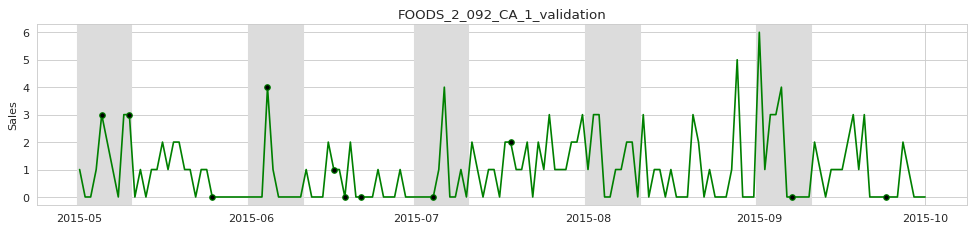

In [62]:
v = event_dates[event_dates['date'].isin([datetime.date(2015,5,1) + datetime.timedelta(days=x) for x in range(153)])]['date']
d = []
for i in range(len(v)):
    d.append(x.columns.get_loc(v.values[i]))   
c = list(set(CA_snap) & set([datetime.date(2015,5,1) + datetime.timedelta(days=x) for x in range(153)]))
e = []
for i in range(len(c)):
    e.append(x.columns.get_loc(c[i]))
    
plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(c)):
    plt.axvline(c[i],color='gainsboro',linewidth=5.5)
plt.plot(x.iloc[0,:], '-gd', markevery = d,markerfacecolor='black',marker='.',markersize=10)
plt.title("FOODS_2_092_CA_1_validation")
plt.ylabel("Sales")
plt.show()

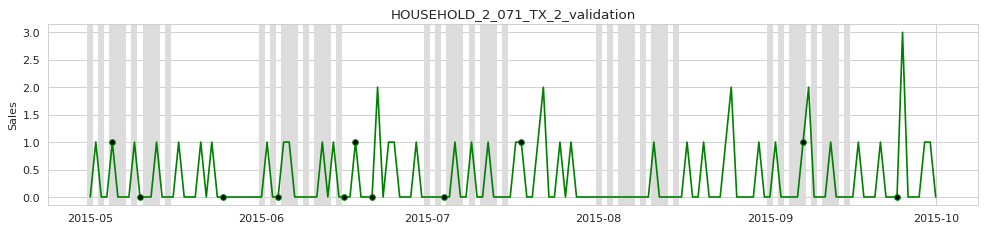

In [63]:
v = event_dates[event_dates['date'].isin([datetime.date(2015,5,1) + datetime.timedelta(days=x) for x in range(153)])]['date']
d = []
for i in range(len(v)):
    d.append(x.columns.get_loc(v.values[i]))   
c = list(set(TX_snap) & set([datetime.date(2015,5,1) + datetime.timedelta(days=x) for x in range(153)]))
e = []
for i in range(len(c)):
    e.append(x.columns.get_loc(c[i]))
    
plt.figure(None, figsize=(15,3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(c)):
    plt.axvline(c[i],color='gainsboro',linewidth=5.5)
plt.plot(x.iloc[1,:], '-gd', markevery = d,markerfacecolor='black',marker='.',markersize=10)
plt.title("HOUSEHOLD_2_071_TX_2_validation")
plt.ylabel("Sales")
plt.show()

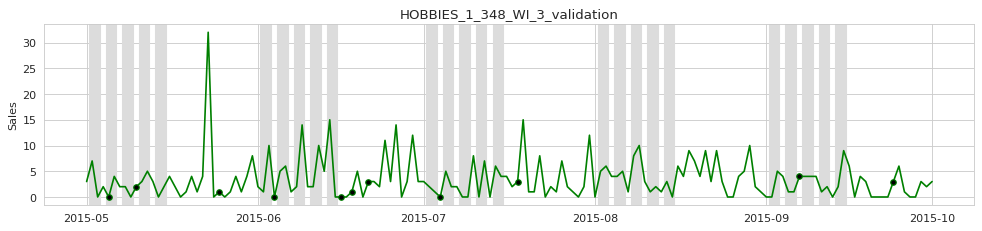

In [64]:
v = event_dates[event_dates['date'].isin([datetime.date(2015,5,1) + datetime.timedelta(days=x) for x in range(153)])]['date']
d = []
for i in range(len(v)):
    d.append(x.columns.get_loc(v.values[i]))   
c = list(set(WI_snap) & set([datetime.date(2015,5,1) + datetime.timedelta(days=x) for x in range(153)]))
e = []
for i in range(len(c)):
    e.append(x.columns.get_loc(c[i]))
    

plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(c)):
    plt.axvline(c[i],color='gainsboro',linewidth=5.5)
plt.plot(x.iloc[2,:], '-gd', markevery = d, markerfacecolor='black',marker='.',markersize=10)
plt.title("HOBBIES_1_348_WI_3_validation")
plt.ylabel("Sales")
plt.show()

# **Doanh số của 3 mặt hàng ngẫu nhiên có sự thay đổi về giá**

In [65]:
import matplotlib
x = sale_train[sale_train['id'].isin(["FOODS_2_092_CA_1_validation", "HOUSEHOLD_2_071_TX_2_validation", "HOBBIES_1_348_WI_3_validation"])].iloc[:,6:]

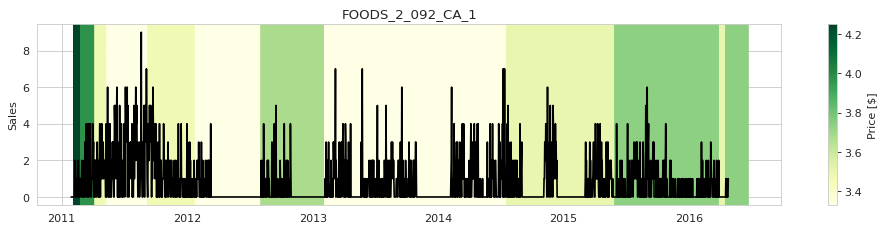

In [66]:
z = sell_prices[(sell_prices['store_id']=='CA_1') & (sell_prices['item_id']=='FOODS_2_092')]
z=calenda[['date','wm_yr_wk']].merge(z[['sell_price','wm_yr_wk']], how='left',on='wm_yr_wk')
z['date']=z['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d').date())
u = z.sell_price.unique()
y = []
u = u[1:]
for i in u:
    y.append(z.groupby(['sell_price']).get_group(i)['date'].values)
    
plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(y)):
    for j in range(len(y[i])):
        plt.axvline(y[i][j],color=matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=u.min(), vmax=u.max()), cmap='YlGn').to_rgba(u[i]))
plt.plot(x.iloc[0,:],color='black')
plt.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=u.min(), vmax=u.max()), cmap='YlGn'),label='Price [$]')
plt.title("FOODS_2_092_CA_1")
plt.ylabel("Sales")
plt.show()

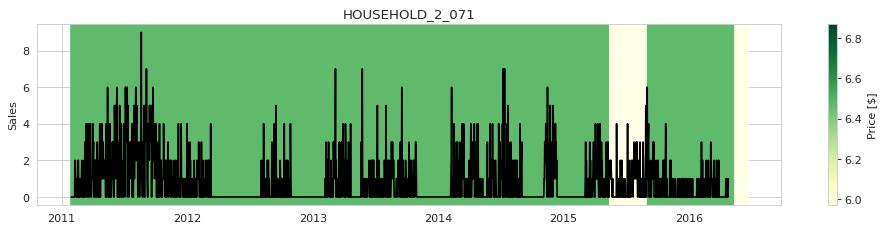

In [67]:
z = sell_prices[(sell_prices['store_id']=='TX_2') & (sell_prices['item_id']=='HOUSEHOLD_2_071')]
z=calenda[['date','wm_yr_wk']].merge(z[['sell_price','wm_yr_wk']], how='left',on='wm_yr_wk')
z['date']=z['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d').date())
u = z.sell_price.unique()
y = []
for i in u:
    y.append(z.groupby(['sell_price']).get_group(i)['date'].values)

plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(y)):
    for j in range(len(y[i])):
        plt.axvline(y[i][j],color=matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=u.min(), vmax=u.max()+0.4), cmap='YlGn').to_rgba(u[i]))
plt.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=u.min(), vmax=u.max()+0.4), cmap='YlGn'),label='Price [$]')
plt.plot(x.iloc[0,:],color='black')
plt.title("HOUSEHOLD_2_071")
plt.ylabel("Sales")
plt.show()

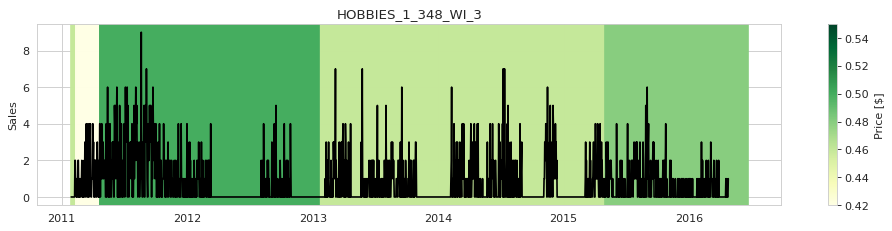

In [68]:
z = sell_prices[(sell_prices['store_id']=='WI_3') & (sell_prices['item_id']=='HOBBIES_1_348')]
z=calenda[['date','wm_yr_wk']].merge(z[['sell_price','wm_yr_wk']], how='left',on='wm_yr_wk')
z['date']=z['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d').date())
u = z.sell_price.unique()
y = []
for i in u:
    y.append(z.groupby(['sell_price']).get_group(i)['date'].values)

plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(y)):
    for j in range(len(y[i])):
        plt.axvline(y[i][j],color=matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=u.min(), vmax=u.max()+0.05), cmap='YlGn').to_rgba(u[i]))
plt.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=u.min(), vmax=u.max()+0.05), cmap='YlGn'),label='Price [$]')
plt.plot(x.iloc[0,:],color='black')
plt.title("HOBBIES_1_348_WI_3")
plt.ylabel("Sales")
plt.show()

# **Doanh số bán của 3 mặt hàng có nền Xám biểu thị ngày SNAP, chấm đen biểu thị Sự kiện và Đường màu vàng biểu thị biên độ Giá**

In [69]:
x = sale_train[sale_train['id'].isin(["FOODS_2_092_CA_1_validation", "HOUSEHOLD_2_071_TX_2_validation", "HOBBIES_1_348_WI_3_validation"])].iloc[:,6:]

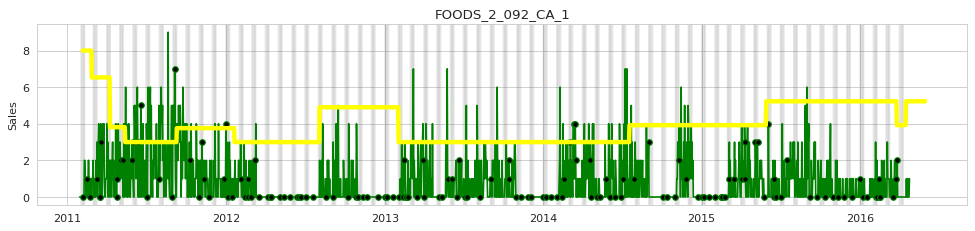

In [70]:
v = event_dates['date']
d = []
for i in range(len(v)):
    d.append(x.columns.get_loc(v.values[i]))   
c = CA_snap[:-20]
e = []
for i in range(len(c)):
    e.append(x.columns.get_loc(c[i]))
    
z = sell_prices[(sell_prices['store_id']=='CA_1') & (sell_prices['item_id']=='FOODS_2_092')]
z=calenda[['date','wm_yr_wk']].merge(z[['sell_price','wm_yr_wk']], how='left',on='wm_yr_wk')
z['date']=z['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d').date())
z['sell_price'] = z['sell_price'].apply(lambda x : (((x - z.sell_price.min()) * (8-3)) / (z.sell_price.max() - z.sell_price.min())) + 3)
z = z.iloc[:-20,:]
z = z.set_index('date')


plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(c)):
    plt.axvline(c[i],color='dimgray',linewidth=0.1)
plt.plot(x.iloc[0,:], '-gd', markevery = d, markerfacecolor='black',marker='.',markersize=10)
plt.plot(z.sell_price,color='yellow',linewidth=4)
plt.title("FOODS_2_092_CA_1")
plt.ylabel("Sales")
plt.show()

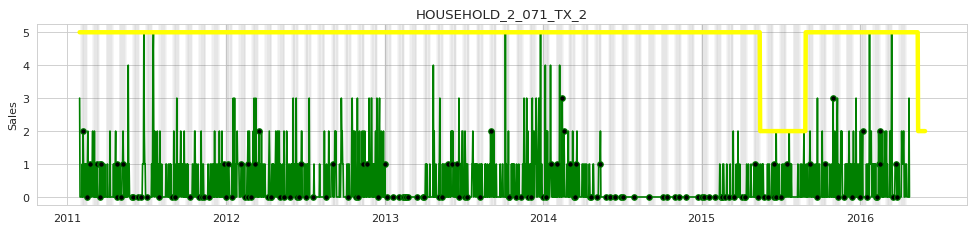

In [71]:
v = event_dates['date']
d = []
for i in range(len(v)):
    d.append(x.columns.get_loc(v.values[i]))   
c = TX_snap[:-20]
e = []
for i in range(len(c)):
    e.append(x.columns.get_loc(c[i]))
    
z = sell_prices[(sell_prices['store_id']=='TX_2') & (sell_prices['item_id']=='HOUSEHOLD_2_071')]
z=calenda[['date','wm_yr_wk']].merge(z[['sell_price','wm_yr_wk']], how='left',on='wm_yr_wk')
z['date']=z['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d').date())
z['sell_price'] = z['sell_price'].apply(lambda x : (((x - z.sell_price.min()) * (5-2)) / (z.sell_price.max() - z.sell_price.min())) + 2)
z = z.iloc[:-20,:]
z = z.set_index('date')


plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(c)):
    plt.axvline(c[i],color='dimgray',linewidth=0.1)
plt.plot(x.iloc[1,:], '-gd', markevery = d, markerfacecolor='black',marker='.',markersize=10)
plt.plot(z.sell_price,color='yellow',linewidth=4)
plt.title("HOUSEHOLD_2_071_TX_2")
plt.ylabel("Sales")
plt.show()

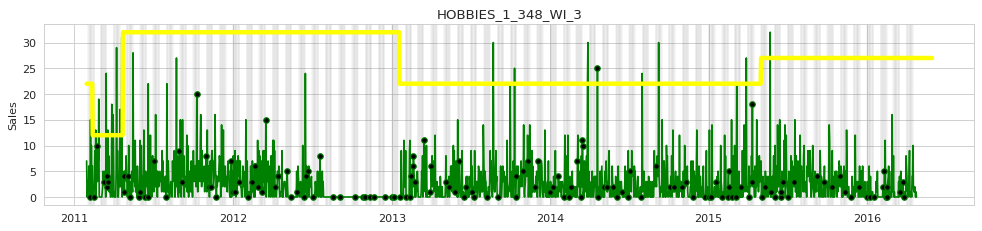

In [72]:
v = event_dates['date']
d = []
for i in range(len(v)):
    d.append(x.columns.get_loc(v.values[i]))   
c = WI_snap[:-20]
e = []
for i in range(len(c)):
    e.append(x.columns.get_loc(c[i]))
    
z = sell_prices[(sell_prices['store_id']=='WI_3') & (sell_prices['item_id']=='HOBBIES_1_348')]
z=calenda[['date','wm_yr_wk']].merge(z[['sell_price','wm_yr_wk']], how='left',on='wm_yr_wk')
z['date']=z['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d').date())
z['sell_price'] = z['sell_price'].apply(lambda x : (((x - z.sell_price.min()) * (32-12)) / (z.sell_price.max() - z.sell_price.min())) + 12)
z = z.iloc[:-20,:]
z = z.set_index('date')


plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(c)):
    plt.axvline(c[i],color='dimgray',linewidth=0.1)
plt.plot(x.iloc[2,:], '-gd', markevery = d, markerfacecolor='black',marker='.',markersize=10)
plt.plot(z.sell_price,color='yellow',linewidth=4)
plt.title("HOBBIES_1_348_WI_3")
plt.ylabel("Sales")
plt.show()